<a href="https://colab.research.google.com/github/MatSci495/Assignments/blob/main/495_Notebook_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BACKGROUND

## Problem Statement
Electrochemical Impedance Spectroscopy (EIS) is a tool used to look at impedance characteristics and behavior of an electrochemical system across a frequency range. It is critical for understanding charge transfer, diffusion, and interfacial phenomena in batteries. With this project, I aim to analyze EIS data from my research in cathode or solid-state electrolyte materials. The EIS data - typically plotted as a Nyquist plot - contain data that can be interpreted using an equivalent circuit model (ECM), which are simplified diagrams of electrical circuits containing capacitors, resistors, and voltage/current sources. This representation of behavior with a physical circuit is helpful in then understanding components in more complex battery systems.

The goal of this project is to build a workflow that imports, processes/cleans, and visualizes EIS data. I aim to fit the data to multiple ECMs to identify the most representative model. Right now, the practice is to visually fit an ECM such that elements like charge-transfer resistance, capacitance, and diffusion can be extracted. This project will help streamline the statistical and error analysis such that an algorithm can quantitatively select the best ECM fit for my EIS spectra and extract more accurate values.

I will test hypotheses regarding different chemical compositions and their interfacial interactions of battery components by comparing the different EIS spectra. This includes obtaining representative ECMs without overfitting, and visualizing the data to test model fit. Existing Python libraries (numpy, pandas, matplotlib, impedance.py) and integrating LLMs will help me create advanced workflows for EIS data analysis.

## Prior Work

[1] Lazanas, A.; Prodromidis, M. Electrochemical Impedance Spectroscopy─A Tutorial *ACS Meas. Sci. Au.* **2023**, 3 (3), 162–193
*   Critical review article to better understand electrochemical impedance spectroscopy (EIS). It is a tutorial for researchers to follow along with, especially with your own data/plots to analyze. Great resource with mathematical models for equivalent circuit models to get started with fitting the right one to any EIS plot.

[2] Iurilli, P; Brivio, C; Wood, V. On the use of electrochemical impedance spectroscopy to characterize and model the aging phenomena of lithium-ion batteries: a critical review, *Journal of Power Sources.* **2021**, 505, 229860
*   This review article discusses how EIS spectra is helpful to understand materials and chemistry phenomenon in lithium-ion batteries. It goes through the typical EIS spectra and analyzes elements that connect to physical properties of batteries.

[3] Gauthier, M. et al. Electrode–Electrolyte Interface in Li-Ion Batteries: Current Understanding and New Insights. *J. Phys. Chem. Lett.* **2015**, 6 (22), 4653–4672
*   This paper goes through the importance of understanding interface interactions between the electrodes and electrolyte in aqueous batteries. It goes through how interfacial resistance and ionic conductivity can be characterized for battery and energy storage research in a lab scale (with coin cells) and how that applies to larger scale production/research.

## Approach to Analysis

1.   Import raw EIS data file.
2.   Process/clean data file by separating metadata from measured values.
3.   Smoothen data (no need to do background removal, focus on if there is unexpected or unusual noise).
4.   Fit to an equivalent circuit model. Start with an initial guess of parameters (resistance & capacitors) based on external understanding of system, or start with the default simplest circuit known as the Randles circuit.
5.   Test fit of initial circuit model to data. Iterate models until the error or difference between experimental and theoretical (modelled) data is minimized.
6.   Plot error.



# LOAD LIBRARIES

Import all libraries needed for the notebook here. Provide brief comments on how they are used in the notebook. Provide a link to documentation for more specialized libraries.

## Library Comments

The impedance python library is crucial to analyzing and understanding EIS data (specified in the commented sections below). The documentation for this library is included here: https://impedancepy.readthedocs.io/en/latest/getting-started.html

## Code Block

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
from scipy.stats import norm

!pip install impedance
from impedance import preprocessing #helps with parsing EIS data
from impedance.models.circuits import CustomCircuit #can input a circuit string to use as an initial euqivalent circuit model (ECM) guess
from impedance.visualization import plot_nyquist #plotting nyquist plots

import requests
from io import StringIO

# IMPORT DATA

Data are imported in this section from GitHub (to enable evaluation by the instructor and class members).

**Class assignments** related to the building of this section include:
*   Data file formatting
*   Loading data

I will be importing EIS spectra directly from a potentiostat. This data includes the imaginary part of impedance (plotted on the y-axis) and the real part of impedance (x-axis). The data file will also have frequency values (at which impedance was peasured), voltages and current.


## Data Import Code

In [12]:
#accessing my personal repository (made public) with data file
url = 'https://raw.githubusercontent.com/shivchatterji/classfiles/refs/heads/main/EIS_simulated_data.txt'
text = requests.get(url).text.splitlines()

In [13]:
metadata = []
data_lines = []

for line in text:
    if line.startswith("###"):
        metadata.append(line)
    else:
        data_lines.append(line)

print("Number of metadata lines:", len(metadata))

Number of metadata lines: 5


In [14]:
#print metadata
for line in metadata:
    cleaned = line.replace("###", "").strip() #removes ### and trailing spaces
    print(cleaned)

EIS DATA FILE
Instrument: Simulated
Number of datasets: 3
Columns: frequency_Hz, Z_real, Z_imag, dataset_id
---------------------------------------------


In [15]:
#parse data

def parse_eis_data(data_lines):
    cleaned = [line.strip() for line in data_lines if line.strip()]

    # Detect delimiter
    sample = cleaned[0]
    if "," in sample:
        delimiter = ","
    elif "\t" in sample:
        delimiter = "\t"
    else:
        delimiter = r"\s+"

    text_block = "\n".join(cleaned)
    df = pd.read_csv(StringIO(text_block), sep=delimiter)

    return df

df_raw = parse_eis_data(data_lines)

In [16]:
#display data

print("\nData Preview:")
display(df_raw)


Data Preview:


,frequency_Hz,Z_real,Z_imag,dataset_id
0,100000.000000,5.529216,-0.209696,1
1,79123.426190,5.120048,-0.117923,1
2,62605.165720,5.293623,-0.256655,1
3,49535.352090,5.672271,-0.533950,1
4,39194.067748,5.560273,0.032924,1
...,...,...,...,...
175,0.255141,123.985167,-7.057451,3
176,0.201876,123.559901,-5.677769,3
177,0.159731,123.996075,-4.608658,3
178,0.126385,123.966845,-2.662576,3


In [17]:
#group by dataset ID
datasets = {k: v for k, v in df_raw.groupby("dataset_id")}

print(f"\nNumber of datasets detected: {len(datasets)}")


Number of datasets detected: 3


## Description of Approach
To complement the comments in the code block, here provide a readable description of your approach and justification for the decisions you made in handling the data.

I need to remove the metadata thats at the top of the raw data file. The software I use to obtain data is called EC Labs, and will output both .txt and excel files for the measurements. I will need to parse and note down the important conditions from the metadata, but then separate it from the rest of the measured data that follows. There is not much cleaning that needs to be done since there is no "background" that appears in EIS spectra. The main noise arises from the difference between different measurement sessions - which could come from a resistance increase with each measurement. This needs to be normalized such that the data can be evenly compared between runs/sessions. The rest of the handling with the data comes from fitting a model (equivalent circuit model) to the data, such that the fit is optimized and the errors are minimized.

For the purposes of this project, I will use simulated EIS data from an LLM.

# DATA CONDITIONING AND EXPLORATION

In this section, carry out data cleaning and formatting necessary for the **Model Fitting and Hypothesis Testing** section. As approriate, develop hypotheses or test initial hypotheses via plotting and visualization to empirically explore mathematical relationships. Document how you refined your methods, i.e. document what approaches were tried and rejected or accepted and why so that others can learn from what did not work. Note that the sub-sections are iterative. For example, data visualization may lead to the identification of outliers that are then removed from the data.

**Class assignments** related to the building of this section include:

*   Data visualization with background subtraction
*   Analysis plan



## Data Cleaning and Conditioning
Includes formatting, filtering, transforming, etc.

Format as mentioned above, where the metadata is stored and removed, such that the actual measured data is reached. No background needs to be subtracted. Rarely will you need to remove an outlier - but it can happen. Check if the measured values make sense/follow a trend, or if certain values need to be removed from the overall dataset. In general, EIS spectra does not include a lot of filtering/transforming for you to move on to the fitting/modelling stage of the data analysis.

Some places where noise arise come from instrument resolution limits, the quality of the cables, environmental interference, and drift during low-frequency measurements. Removing this noise will help better fit equivalent circuit models (ECMs) to the data.

Data will be smoothed using a Savitzky-Golay filter. This method fits a low-degree polynomial to the data, identifies a small moving window around each data point, uses least-squares regression, and finally replaces the central point with a value produced by the polynomial fit. This method helps retain curvature and peak shapes while cleaning up some noise from the data. Instead of using a simple moving average which is another common noise-reduction method, the Savitzky-Golay method makes more sense for EIS as it maintains the semicircle curvature and diffusion tail features without distorting them. EIS features carry physical meaning and therefore the distortions from a moving average can result in inaccurate data processing/analysis.

## Data Exploration and Visualization

Need to look at resistance values (if the data forms a typical semi-circle) or if the resistance dominates (and therefore creates more of an open curve/semi-circle doesn't return back to the x-axis). There is also the diffusion tail that is critical in understanding the physical phenomenon of batteries. Usually for spent/cycled batteries, the diffusion tail when performing EIS is much more prominent/obvious. All of these elements regarding the shape and values that arise from measuring EIS of a cell will help identify what equivalent circuit model can be initially tested. After that, depending on which element differs the most, additional circuit elements will be added to the model, and error will be calculated such that this workflow will be able to identify which fit/model is best for the data that I have obtained.

In [18]:
#smooth data using Savitzky–Golay filter

def smooth_dataset(df):
    df = df.copy()
    df["Z_real_smooth"] = savgol_filter(df["Z_real"], window_length=7, polyorder=2)
    df["Z_imag_smooth"] = savgol_filter(df["Z_imag"], window_length=7, polyorder=2)
    return df

datasets_smooth = {k: smooth_dataset(v) for k,v in datasets.items()}

# PARAMETER ESTIMATION AND MODEL TESTING

This section quantitatively compares expectations of a model with trends in the data. It will include measures of goodness of fit including confidence intervals when appropriate. References to the models being considered should be provided in the **BACKGROUND** section. Use sub-sections to show the interative refinement of your approach, i.e. do not simply include the final "best fit", but document at least one analysis approach or model that was considered less optimal.

*   Approaches to Background Fitting (Lecture)

Background will not need to be fitted/removed for EIS data. The models that will be fit to the data follow references 1-2 listed in the background section. These references detail out the common elements to identify and focus on regarding battery research, as well as which models to start with (and what circuit elements to try first and iterate to test if the fit gets better).

## Best Fit/Model/Approach

In [22]:
#set up model and residuals

def randles_impedance(Rs, Rct, Cdl, w): #Randles impedance model
    return Rs + 1 / (1/Rct + 1j*w*Cdl)

def residuals(params, w, Z_exp):
    Rs, Rct, Cdl = params
    Z_model = randles_impedance(Rs, Rct, Cdl, w)
    res = np.concatenate([
        (Z_model.real - Z_exp.real),
        (Z_model.imag - Z_exp.imag)
    ])
    return res

In [24]:
#fit each dataset

fit_results = {}

for ds_id, df in datasets_smooth.items():
    freq = df["frequency_Hz"].values
    w = 2*np.pi*freq
    Z_exp = df["Z_real_smooth"].values + 1j*df["Z_imag_smooth"].values

    # initial guess
    params0 = [5, 50, 1e-4]

    result = least_squares(residuals, params0, args=(w, Z_exp))
    Rs_fit, Rct_fit, Cdl_fit = result.x

    fit_results[ds_id] = {
        "params": result.x,
        "Z_fit": randles_impedance(Rs_fit, Rct_fit, Cdl_fit, w),
        "df": df
    }

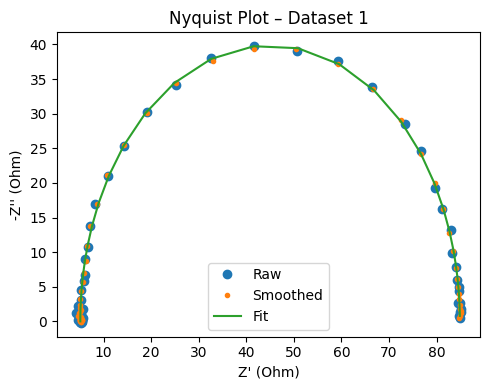

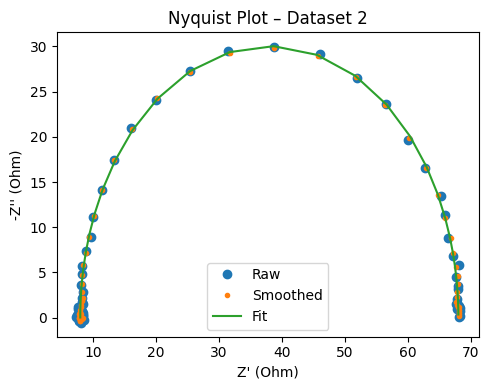

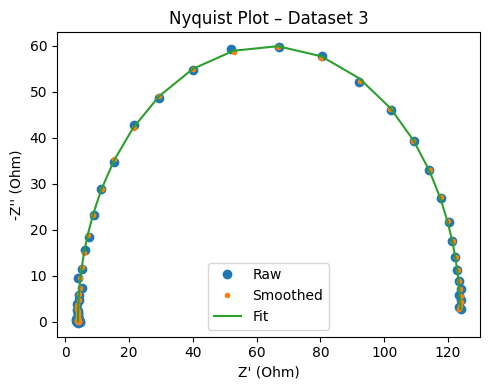

In [25]:
#plot data and model fit

for ds_id, info in fit_results.items():
    df = info["df"]
    Z_fit = info["Z_fit"]

    plt.figure(figsize=(5,4))
    plt.plot(df["Z_real"], -df["Z_imag"], "o", label="Raw")
    plt.plot(df["Z_real_smooth"], -df["Z_imag_smooth"], ".", label="Smoothed")
    plt.plot(Z_fit.real, -Z_fit.imag, label="Fit")
    plt.xlabel("Z' (Ohm)")
    plt.ylabel("-Z'' (Ohm)")
    plt.title(f"Nyquist Plot – Dataset {ds_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()

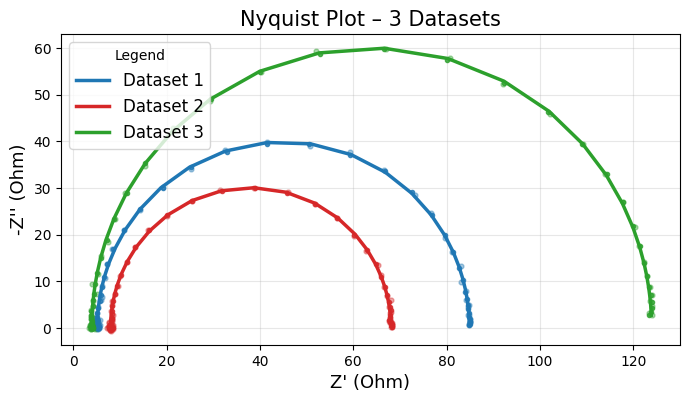

In [26]:
#output a plot for the final presentation

plt.figure(figsize=(7,6))

colors = ["#1f77b4", "#d62728", "#2ca02c"]  # blue, red, green
for (ds_id, info), c in zip(fit_results.items(), colors):
    df = info["df"]
    Z_fit = info["Z_fit"]

    # plot raw
    plt.scatter(df["Z_real"], -df["Z_imag"], s=12, alpha=0.4, color=c)

    # plot smoothed
    plt.plot(df["Z_real_smooth"], -df["Z_imag_smooth"], ".", color=c, alpha=0.8)

    # plot fit
    plt.plot(Z_fit.real, -Z_fit.imag, color=c, lw=2.5, label=f"Dataset {ds_id}")

plt.xlabel("Z' (Ohm)", fontsize=13)
plt.ylabel("-Z'' (Ohm)", fontsize=13)
plt.title("Nyquist Plot – 3 Datasets", fontsize=15)

plt.grid(alpha=0.3)
plt.legend(title="Legend", fontsize=12)
plt.gca().set_aspect("equal", adjustable="box")  # important for semicircles
plt.tight_layout()
plt.show()

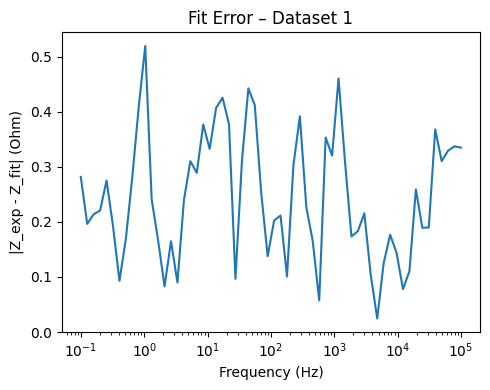

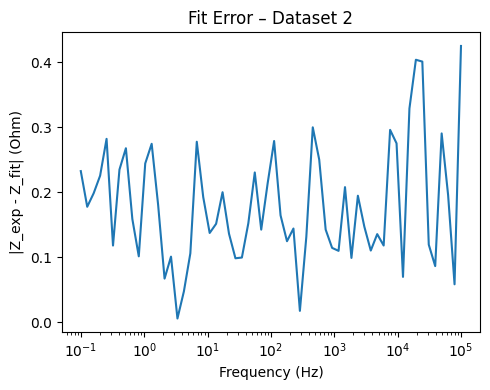

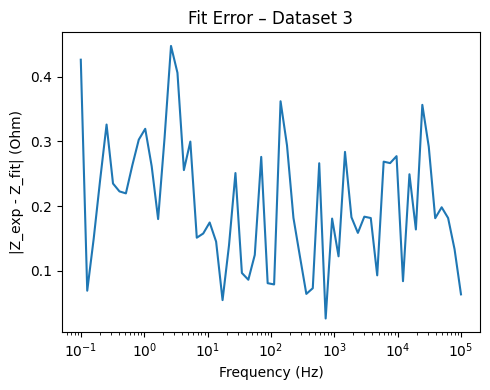


=== Dataset 1 Fit Parameters ===
Rs  = 5.1238
Rct = 79.7593
Cdl = 2.012779e-04

=== Dataset 2 Fit Parameters ===
Rs  = 7.9747
Rct = 60.0868
Cdl = 1.499555e-04

=== Dataset 3 Fit Parameters ===
Rs  = 3.9457
Rct = 119.9952
Cdl = 2.992910e-04


In [27]:
#plot error vs. frequency

for ds_id, info in fit_results.items():
    df = info["df"]
    Z_fit = info["Z_fit"]
    Z_exp = df["Z_real_smooth"].values + 1j*df["Z_imag_smooth"].values

    error = np.abs(Z_exp - Z_fit)

    plt.figure(figsize=(5,4))
    plt.plot(df["frequency_Hz"], error)
    plt.xscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|Z_exp - Z_fit| (Ohm)")
    plt.title(f"Fit Error – Dataset {ds_id}")
    plt.tight_layout()
    plt.show()

#fitting parameters:
for ds_id, info in fit_results.items():
    Rs, Rct, Cdl = info["params"]
    print(f"\n=== Dataset {ds_id} Fit Parameters ===")
    print(f"Rs  = {Rs:.4f}")
    print(f"Rct = {Rct:.4f}")
    print(f"Cdl = {Cdl:.6e}")

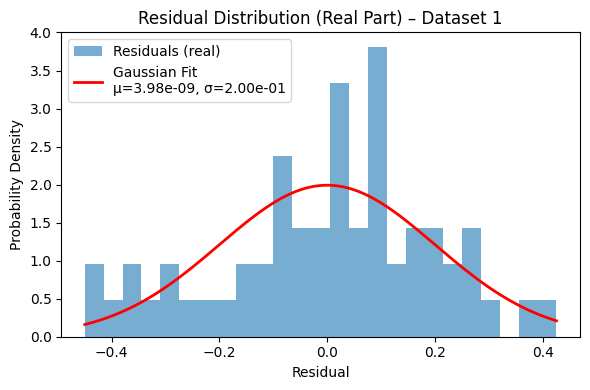

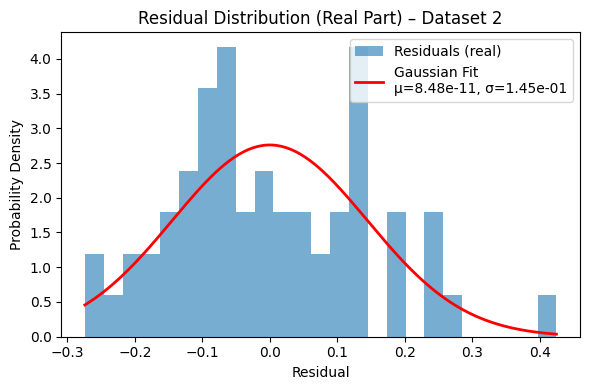

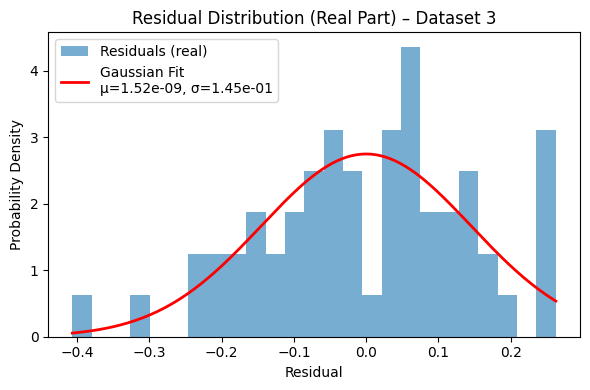

In [30]:
#show normal distribution for error

for ds_id, info in fit_results.items():
    df = info["df"]
    Z_fit = info["Z_fit"]
    Z_exp = df["Z_real_smooth"].values + 1j * df["Z_imag_smooth"].values

    # residuals
    res_real = (Z_exp - Z_fit).real
    res_imag = (Z_exp - Z_fit).imag

    plt.figure(figsize=(6,4))

    # histogram
    count, bins, _ = plt.hist(res_real, bins=25, density=True, alpha=0.6, label="Residuals (real)")

    # Gaussian fit
    mu, sigma = norm.fit(res_real)
    x = np.linspace(min(bins), max(bins), 200)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f"Gaussian Fit\nμ={mu:.2e}, σ={sigma:.2e}")

    plt.title(f"Residual Distribution (Real Part) – Dataset {ds_id}")
    plt.xlabel("Residual")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

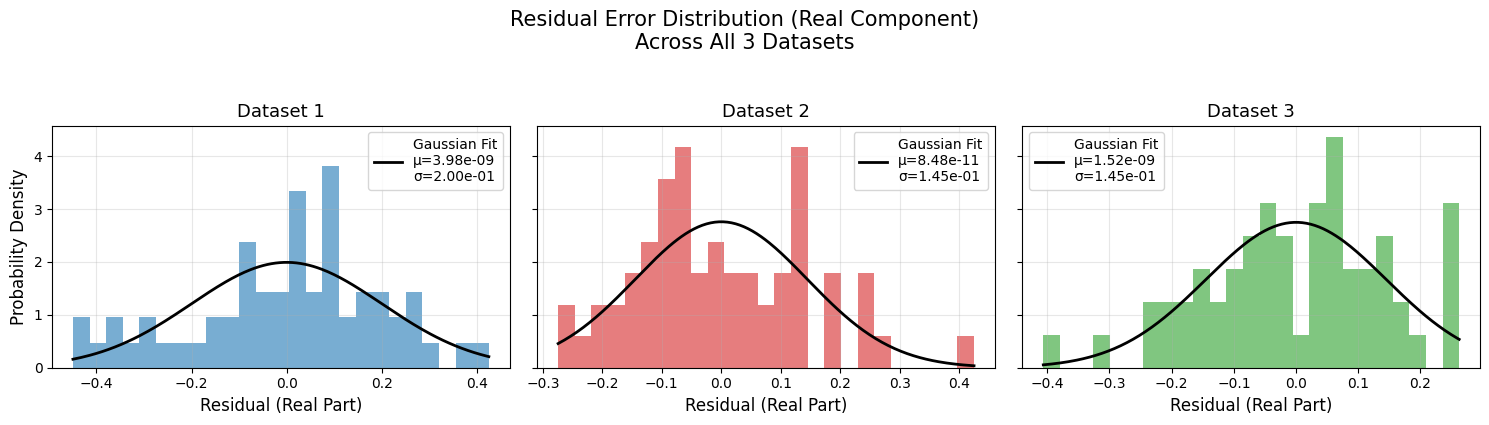

In [31]:
#output a figure for the final presentation

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)

colors = ["#1f77b4", "#d62728", "#2ca02c"]  # blue, red, green

for ax, (ds_id, info), c in zip(axes, fit_results.items(), colors):

    df = info["df"]
    Z_fit = info["Z_fit"]
    Z_exp = df["Z_real_smooth"].values + 1j * df["Z_imag_smooth"].values

    # REAL PART residuals only
    res_real = (Z_exp - Z_fit).real

    # Fit Gaussian distribution
    mu, sigma = norm.fit(res_real)

    # Plot histogram of residuals
    counts, bins, _ = ax.hist(res_real, bins=25, density=True, alpha=0.6, color=c)

    # Gaussian curve
    x = np.linspace(min(bins), max(bins), 200)
    ax.plot(x, norm.pdf(x, mu, sigma), "k-", linewidth=2,
            label=f"Gaussian Fit\nμ={mu:.2e}\nσ={sigma:.2e}")

    ax.set_title(f"Dataset {ds_id}", fontsize=13)
    ax.set_xlabel("Residual (Real Part)", fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=10)

axes[0].set_ylabel("Probability Density", fontsize=12)

plt.suptitle("Residual Error Distribution (Real Component)\nAcross All 3 Datasets",
              fontsize=15, y=1.05)

plt.tight_layout()
plt.show()

## Initial Model/Approach

In [53]:
#additional models

#1. ideal capacitor (no Rct: charge-transfer resistance). too simplified for my data

def cap_ideal(Rs, Cdl, w):
    Zc = 1 / (1j * w * Cdl)
    return Rs + Zc

def residuals_cap_ideal(params, w, Z_exp):
    Rs, Cdl = params
    Z_model = cap_ideal_model(Rs, Cdl, w)
    return np.concatenate([
        (Z_model.real - Z_exp.real),
        (Z_model.imag - Z_exp.imag)
    ])

#2. Randles circuit with finite Warburg diffusion element. more complicated than my data requires

def randles_warburg(Rs, Rct, Cdl, W, w):
    Zw = W / np.sqrt(w) * (1 - 1j)
    return Rs + 1 / (1/Rct + 1j*w*Cdl) + Zw


def residuals_warburg(params, w, Z_exp):
    Rs, Rct, Cdl, W = params
    Z_model = randles_warburg(Rs, Rct, Cdl, W, w)

    res = np.concatenate([
        (Z_model.real - Z_exp.real),
        (Z_model.imag - Z_exp.imag)
    ])
    return res

Parameters:
Rs  = 37.3284
Cdl = 9.330516e-02


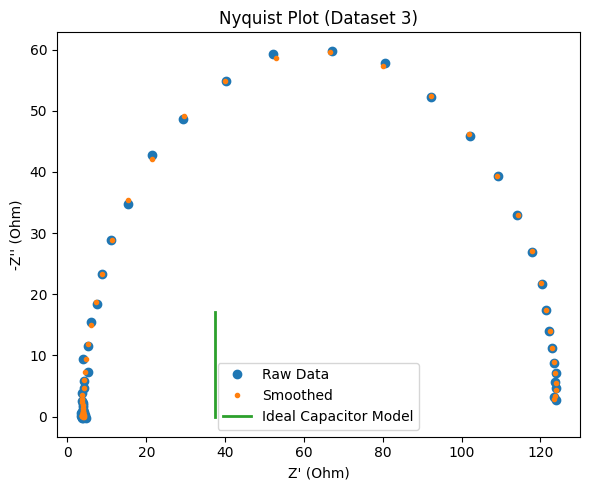

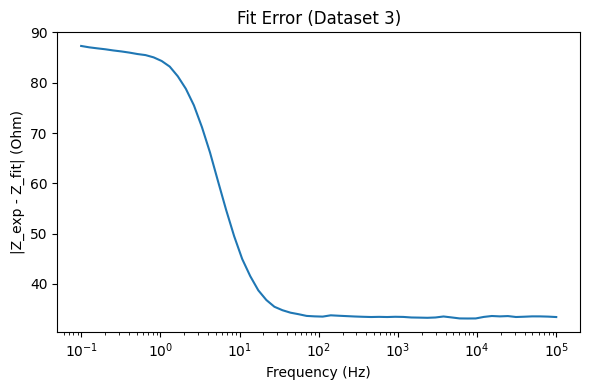

In [54]:
#will show why the ideal capacitor model is not a good fit:

#prepare the data (will use dataset 3)
freq = df["frequency_Hz"].values
w = 2 * np.pi * freq

#smoothed experimental impedance
Z_exp = df["Z_real_smooth"].values + 1j * df["Z_imag_smooth"].values

#fit model
params0 = [5, 1e-4]

result = least_squares(residuals_wrong, params0, args=(w, Z_exp))
Rs_fit, Cdl_fit = result.x

Z_fit = cap_ideal(Rs_fit, Cdl_fit, w)

print("Parameters:")
print(f"Rs  = {Rs_fit:.4f}")
print(f"Cdl = {Cdl_fit:.6e}")

plt.figure(figsize=(6,5))

plt.plot(df["Z_real"], -df["Z_imag"], "o", label="Raw Data")
plt.plot(df["Z_real_smooth"], -df["Z_imag_smooth"], ".", label="Smoothed")
plt.plot(Z_fit.real, -Z_fit.imag, "-", label="Ideal Capacitor Model", linewidth=2)

plt.xlabel("Z' (Ohm)")
plt.ylabel("-Z'' (Ohm)")
plt.title(f"Nyquist Plot (Dataset {ds_id})")
plt.legend()
plt.tight_layout()
plt.show()

error = np.abs(Z_exp - Z_fit)

plt.figure(figsize=(6,4))
plt.plot(freq, error)
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Z_exp - Z_fit| (Ohm)")
plt.title(f"Fit Error (Dataset {ds_id})")
plt.tight_layout()
plt.show()

# DISCUSSION

This section provides a discussion of the findings of the previous section, including models or approaches that were rejected and why.  

**Class assignments** related to the building of this section include:


*   Approaches to Background Fitting (Lecture)


Sticking points:
*   How do you deal with multiple equivalent circuit models obtaining the same "fit" with your data? How do you connect each element to physical phenomenon - and where does that connection to real life applications break down in terms of data analysis?
*   Above I discussed how most of the noise in EIS spectra comes from the difference between runs (and not from a single run since EIS curves are generally quite smooth). Are there other points where noise can arise when measuring EIS spectra?